In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# 1. 데이터 생성
def create_sequence_data(sequence_length, num_sequences, period=50):
    """
    사인(sine) 파동 시계열 데이터를 생성합니다.
    """
    data = []
    for _ in range(num_sequences):
        start_point = np.random.rand() * period # 시작점을 무작위로 설정하여 다양한 시퀀스 생성
        sequence = np.sin(np.linspace(start_point, start_point + sequence_length, sequence_length) * 2 * np.pi / period)
        data.append(sequence)
    return np.array(data)

In [5]:
# 시퀀스 길이 (과거 몇 개의 데이터를 볼 것인가)
sequence_length = 20
# 전체 시퀀스 수 (데이터셋 크기)
num_sequences = 1000
# 예측할 다음 스텝 수
prediction_length = 1

In [6]:

# 데이터 생성
raw_data = create_sequence_data(sequence_length + prediction_length, num_sequences)

In [7]:
raw_data

array([[-0.99556619, -0.99928778, -0.98563702, ...,  0.65186776,
         0.74597104,  0.8271058 ],
       [-0.11128789, -0.24106764, -0.3666565 , ..., -0.6091828 ,
        -0.4995531 , -0.3812388 ],
       [-0.63498365, -0.73110097, -0.81450829, ..., -0.07848046,
         0.05336029,  0.18427338],
       ...,
       [ 0.93656621,  0.88231315,  0.8127213 , ..., -0.91773613,
        -0.96201496, -0.98956941],
       [ 0.4690935 ,  0.3488251 ,  0.22249247, ..., -0.95049117,
        -0.90134531, -0.83652981],
       [ 0.85217251,  0.91360761,  0.95915987, ..., -0.25086588,
        -0.37604243, -0.49468159]])

In [8]:


# 학습 데이터와 테스트 데이터 분리
train_size = int(0.8 * num_sequences)
train_data = raw_data[:train_size]
test_data = raw_data[train_size:]

# 입력 (X)과 출력 (Y) 분리
# X는 과거 sequence_length 만큼의 데이터
# Y는 그 다음 prediction_length 만큼의 데이터 (여기서는 1 스텝 다음 값)
def prepare_data_for_lstm(data, sequence_length, prediction_length):
    X = []
    Y = []
    for seq in data:
        X.append(seq[:sequence_length])
        Y.append(seq[sequence_length:sequence_length + prediction_length])
    return np.array(X), np.array(Y)

X_train_np, Y_train_np = prepare_data_for_lstm(train_data, sequence_length, prediction_length)
X_test_np, Y_test_np = prepare_data_for_lstm(test_data, sequence_length, prediction_length)

In [10]:


# NumPy 배열을 PyTorch Tensor로 변환
# LSTM 입력 형태: (batch_size, sequence_length, input_size)
# 여기서는 각 시점의 입력이 1개의 특징을 가지므로 input_size=1
X_train = torch.FloatTensor(X_train_np).unsqueeze(-1)
Y_train = torch.FloatTensor(Y_train_np).unsqueeze(-1)
X_test = torch.FloatTensor(X_test_np).unsqueeze(-1)
Y_test = torch.FloatTensor(Y_test_np).unsqueeze(-1)

print(f"X_train shape: {X_train.shape}") # 예: torch.Size([800, 20, 1])
print(f"Y_train shape: {Y_train.shape}") # 예: torch.Size([800, 1, 1])


X_train shape: torch.Size([800, 20, 1])
Y_train shape: torch.Size([800, 1, 1])


In [11]:

# 2. LSTM 모델 정의
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # batch_first=True는 입력 텐서의 첫 번째 차원이 배치 사이즈임을 의미합니다.
        # 즉, (batch_size, sequence_length, input_size) 형태의 입력을 받습니다.
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # LSTM의 최종 출력은 hidden_size 크기이므로, 이를 output_size로 매핑하는 Linear 계층
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM의 초기 hidden state와 cell state를 0으로 초기화
        # h0, c0의 형태: (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM 순전파
        # output: 모든 시점의 출력 (batch_size, sequence_length, hidden_size)
        # (hn, cn): 최종 시점의 hidden state와 cell state
        lstm_out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # 마지막 시점의 hidden state를 사용하여 최종 예측
        # lstm_out[:, -1, :]는 마지막 시점의 모든 hidden_size 특징을 가져옵니다.
        out = self.fc(lstm_out[:, -1, :])
        return out

In [12]:
# 3. 모델 인스턴스화, 손실 함수, 옵티마이저 설정
input_size = 1 # 각 시점의 특징 개수 (여기서는 사인 값 1개)
hidden_size = 50 # LSTM 은닉 상태의 크기
num_layers = 2 # LSTM 계층의 수
output_size = 1 # 예측할 출력의 크기 (다음 스텝의 값 1개)

model = LSTMRegressor(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss() # 평균 제곱 오차 손실
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:

# GPU 사용 설정 (가능하다면)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

# 4. 모델 학습
num_epochs = 200

for epoch in range(num_epochs):
    model.train() # 모델을 훈련 모드로 설정
    
    # 순전파
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    
    # 역전파 및 최적화
    optimizer.zero_grad() # 이전 기울기 초기화
    loss.backward()       # 역전파
    optimizer.step()      # 가중치 업데이트
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/200], Loss: 0.4950
Epoch [20/200], Loss: 0.4949
Epoch [30/200], Loss: 0.4949
Epoch [40/200], Loss: 0.4949
Epoch [50/200], Loss: 0.4949
Epoch [60/200], Loss: 0.4949
Epoch [70/200], Loss: 0.4949
Epoch [80/200], Loss: 0.4949
Epoch [90/200], Loss: 0.4949
Epoch [100/200], Loss: 0.4949
Epoch [110/200], Loss: 0.4949
Epoch [120/200], Loss: 0.4949
Epoch [130/200], Loss: 0.4949
Epoch [140/200], Loss: 0.4949
Epoch [150/200], Loss: 0.4949
Epoch [160/200], Loss: 0.4949
Epoch [170/200], Loss: 0.4949
Epoch [180/200], Loss: 0.4949
Epoch [190/200], Loss: 0.4949
Epoch [200/200], Loss: 0.4949


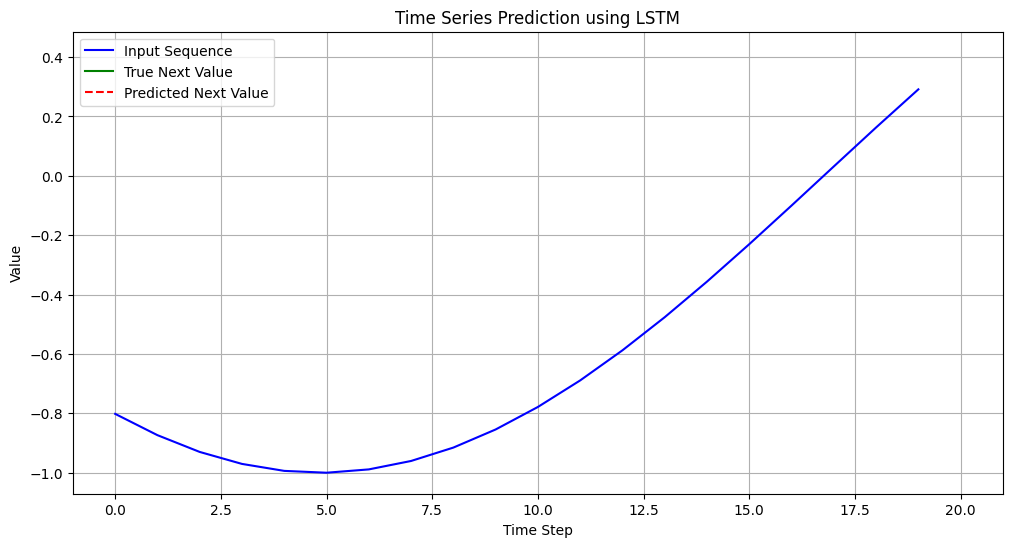

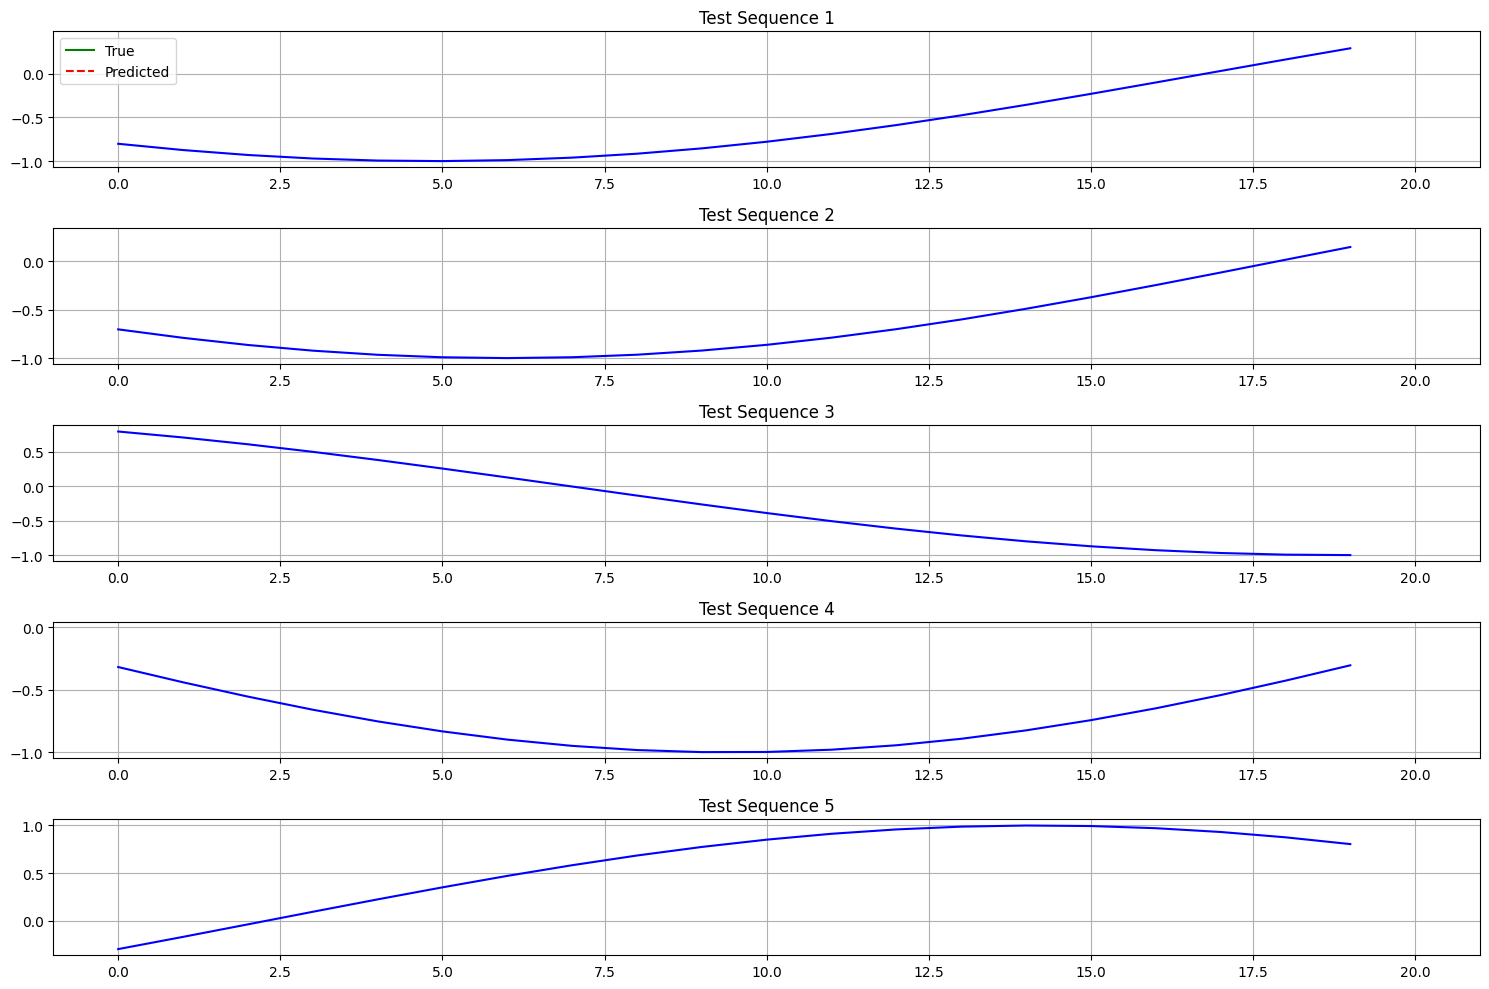

In [14]:


# 5. 모델 평가 및 예측
model.eval() # 모델을 평가 모드로 설정 (dropout, batchnorm 등이 비활성화됨)
with torch.no_grad(): # 기울기 계산 비활성화
    test_predictions = model(X_test).cpu().numpy() # 예측 후 CPU로 이동하여 NumPy 변환

# 시각화 (첫 번째 테스트 시퀀스에 대한 예측)
plt.figure(figsize=(12, 6))

# 원본 테스트 시퀀스 (입력 + 정답)
# NumPy 배열로 다시 변환하고 차원 축소
original_test_sequence = X_test_np[0].flatten()
true_next_value = Y_test_np[0].flatten()

# 예측값
predicted_next_value = test_predictions[0].flatten()

# 전체 시퀀스 플롯
plt.plot(np.arange(sequence_length), original_test_sequence, 'b-', label='Input Sequence')
plt.plot(np.arange(sequence_length, sequence_length + prediction_length), true_next_value, 'g-', label='True Next Value')
plt.plot(np.arange(sequence_length, sequence_length + prediction_length), predicted_next_value, 'r--', label='Predicted Next Value')

plt.title('Time Series Prediction using LSTM')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 여러 테스트 시퀀스에 대한 예측 및 실제 값 비교 (선택 사항)
num_samples_to_plot = 5
plt.figure(figsize=(15, 10))
for i in range(num_samples_to_plot):
    plt.subplot(num_samples_to_plot, 1, i + 1)
    
    original_seq = X_test_np[i].flatten()
    true_next = Y_test_np[i].flatten()
    predicted_next = test_predictions[i].flatten()

    plt.plot(np.arange(sequence_length), original_seq, 'b-')
    plt.plot(np.arange(sequence_length, sequence_length + prediction_length), true_next, 'g-', label='True')
    plt.plot(np.arange(sequence_length, sequence_length + prediction_length), predicted_next, 'r--', label='Predicted')
    
    if i == 0:
        plt.legend()
    plt.title(f'Test Sequence {i+1}')
    plt.grid(True)
plt.tight_layout()
plt.show()